# Disclaimer

The information in this script are provided for general information or educational purposes only and do not constitute legal or other professional advice on any subject matter. This tool doesn’t accept any responsibility for any loss that may arise from reliance on information contained in this script. 

This script may include some technical or other mistakes, inaccuracies or typographical errors. We may make changes to the material/descriptions/content at anytime without any notice. The materials of this script may be out of date, and we make no single commitment to update such materials!

The use of this website is done at your own DISCRETION and risk and with your agreement that you will be solely responsible for any conditions!

# What we will cover

1. Loading the data
2. Analyzing the data
3. Creating a bulksheet with negative targets

# Why work with Amazon Advertising Bulksheets?

1. Complete campaign structure
2. Includes performance metrics and searchterm data
3. Easy to get

# Why work with Jupyter Notebooks / Pandas?

- Excel as code + much more
- Lot's of libraries for Python
- Once created it runs in seconds
- Repetitive tasks
- Can be customized to your needs
- Runs in your browser

# Prerequisites

- Knowledge of working with Python / Pandas / Jupyter Notebooks
- Amazon advertising knowledge
- Local installation of Anaconda or access to Google Colab


# Create and download the bulksheet

Create the bulksheet here: https://advertising.amazon.de/bulksheet/HomePage

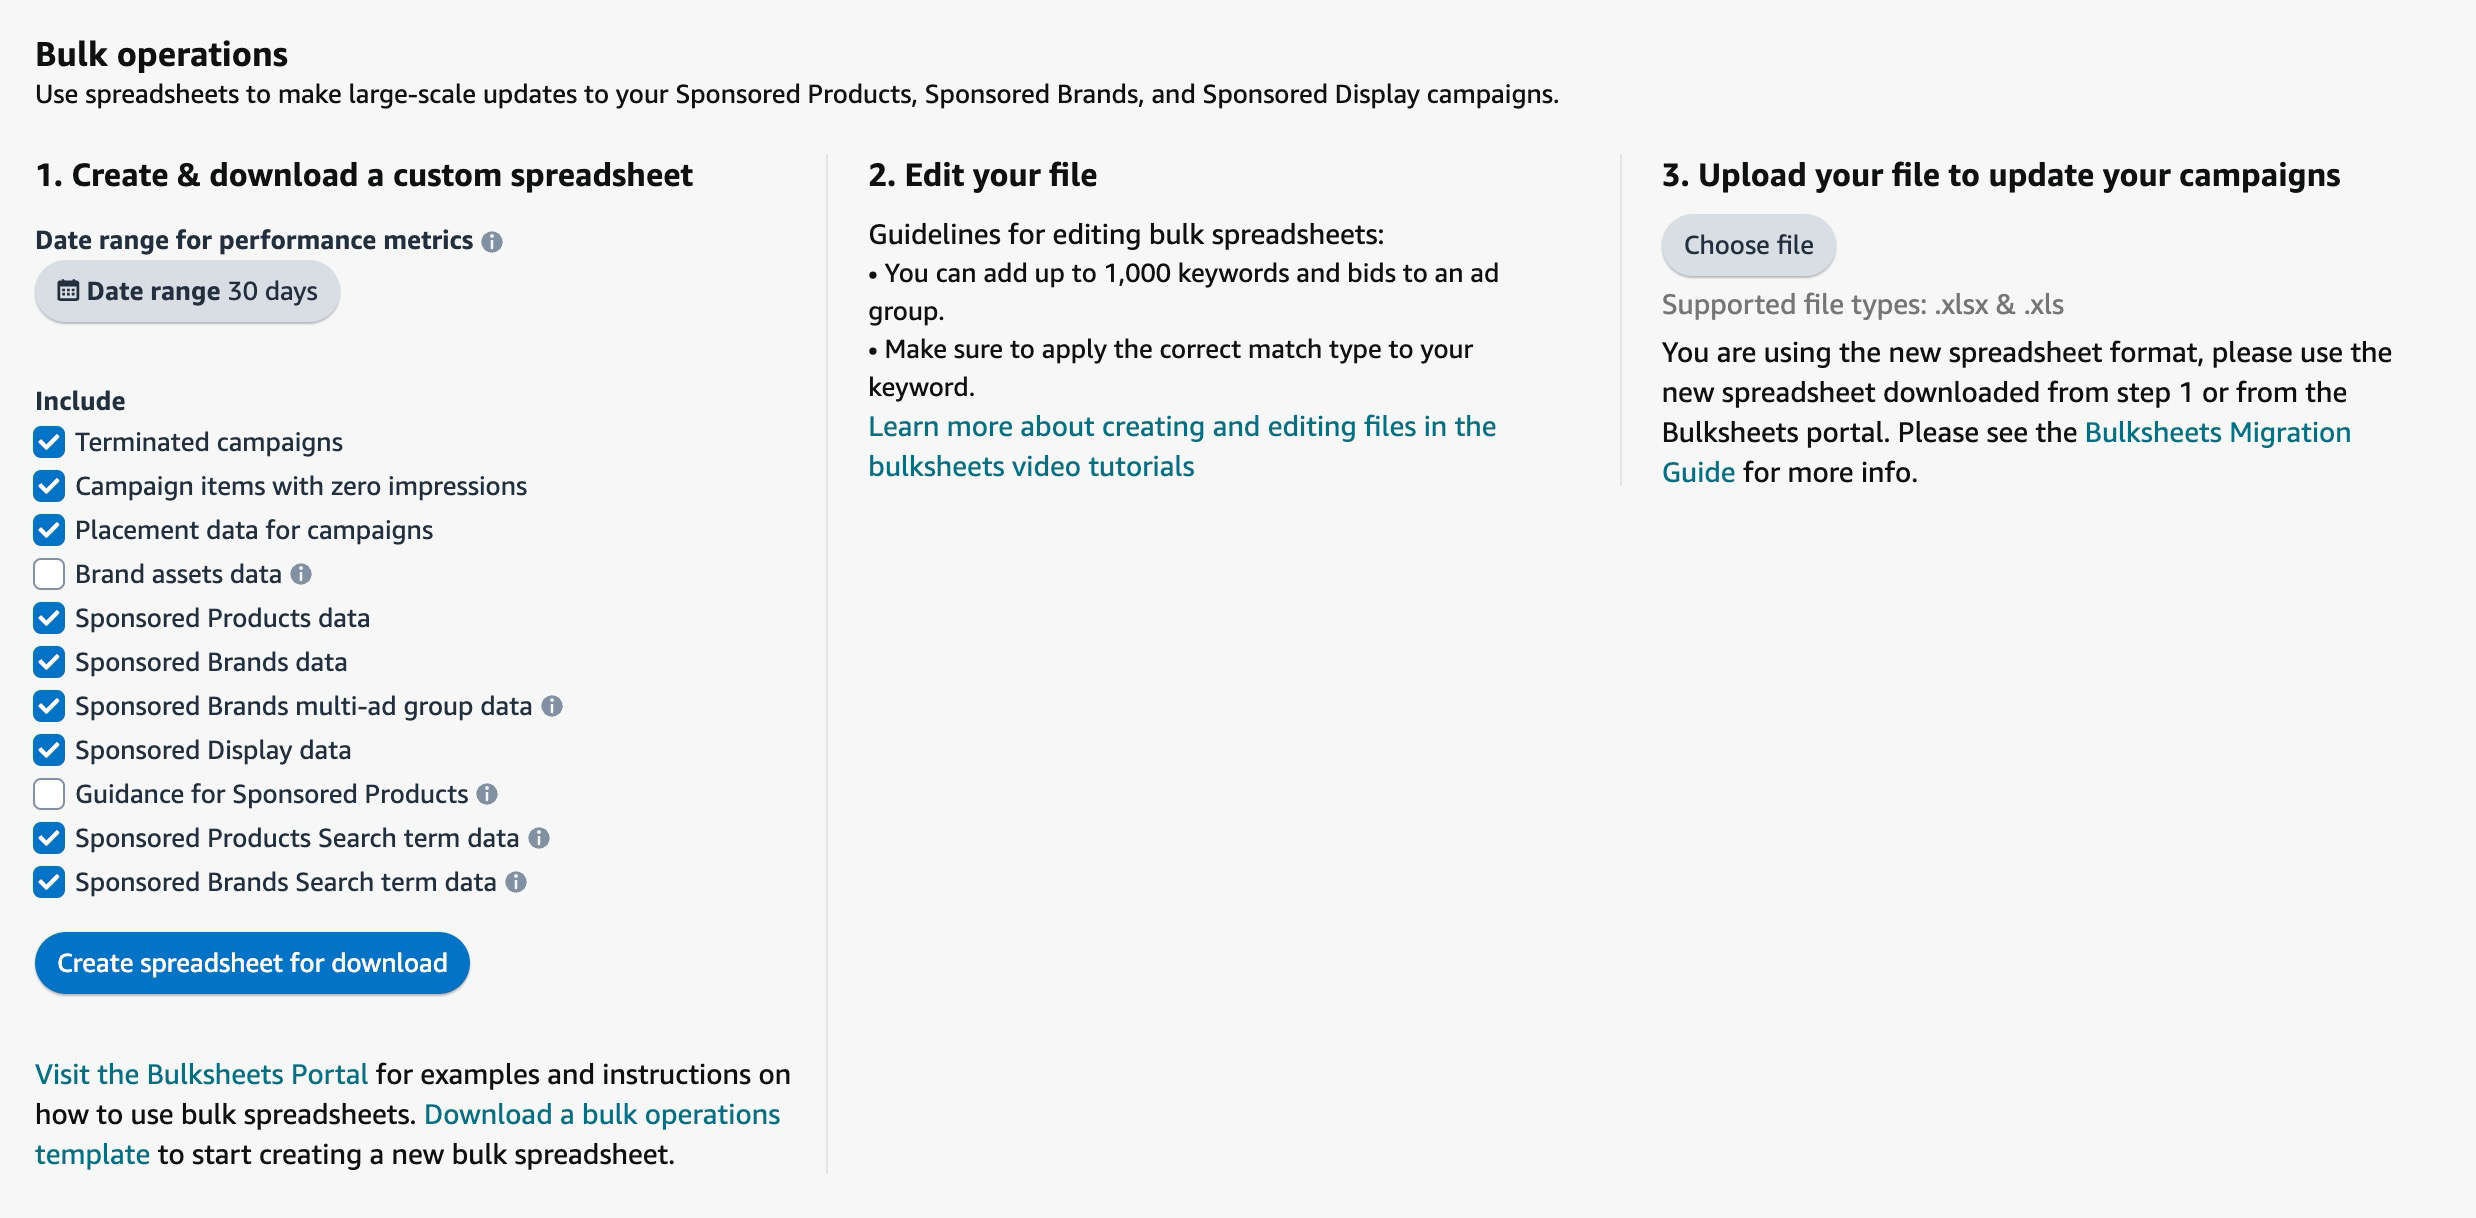

# Quick first look at the data


In [ ]:
import pandas as pd

bulksheet_filename_english = "bulk-abcdefghijklm-20240430-20240501-1714590364233.xlsx"

xls = pd.ExcelFile(bulksheet_filename_english)
df_english = pd.read_excel(xls, 'Sponsored Products Campaigns', engine="openpyxl")
df_english

In [ ]:
print(df_english.columns)

In [ ]:
bulksheet_filename_german = "bulk-abcdefghijklm-20240401-20240428-1234567890123-german.xlsx"
xls = pd.ExcelFile(bulksheet_filename_german)

df_german = pd.read_excel(xls, 'Sponsored Products-Kampagnen', engine="openpyxl")
df_german

In [ ]:
print(df_german.columns)

In [ ]:
from skimpy import clean_columns
df_english = clean_columns(df_english)
df_english.columns

# Let's get started - Load dependencies

In [ ]:
#!pip install skimpy

In [ ]:
import pandas as pd
import numpy as np
import time
import datetime
from skimpy import clean_columns
import warnings
import copy
import re


import matplotlib.pyplot as plt
import seaborn as sns

# Show all columns
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.precision', 2) # Show 2 digits

# Charting settings

# Makes plots appear in the notebook
%matplotlib inline 

# Use seaborn styling
sns.set()  

# Don't show warning messages
warnings.filterwarnings('ignore')

# Show version
print("Pandas version: " + pd.__version__)
!python --version

# Variables

In [ ]:
# Sheet names in english Excel file

# Portfolios
sheetPortfolios = 'Portfolios'

# Sponsored Products
sheetSP   = 'Sponsored Products Campaigns'
sheetSPST = 'SP Search Term Report'

# Sponsored Brands
sheetSB_No_Adgroups    = 'Sponsored Brands Campaigns'
sheetSB_Multi_Adgroups = 'SB Multi Ad Group Campaigns'
sheetSBST              = 'SB Search Term Report'

# Sponsored Display
sheetSD                = 'Sponsored Display Campaigns'

# Column names in English

# Sponsored Products
cProduct = 'product'
cEntity = 'entity'
cOperation = 'operation'
cCampaignID = 'campaign_id'
cAdgroupID = 'ad_group_id'
cPortfolioID = 'portfolio_id'
cAdID = 'ad_id'
cKeywordID = 'keyword_id'
cProductTargetingID = 'product_targeting_id'
cCampaignname = 'campaign_name'
cAdgroupname = 'ad_group_name'
cCampaignnameInformationalOnly = 'campaign_name_informational_only'
cAdgroupnameInformationalOnly = 'ad_group_name_informational_only'
cPortfolioNameInformationalOnly = 'portfolio_name_informational_only'
cStartdate = 'start_date'
cEnddate = 'end_date'
cTargetingType = 'targeting_type'
cState = 'state'
cCampaignStateInformationalOnly = 'campaign_state_informational_only'
cAdGroupStateInformationalOnly = 'ad_group_state_informational_only'
cDailyBudget = 'daily_budget'
cSKU = 'sku'
cASIN = 'asin'
cASINInformationalOnly = 'asin_informational_only'
cEligibilityStatusInformationalOnly = 'eligibility_status_informational_only'
cReasonForIneligibilityInformationalOnly = 'reason_for_ineligibility_informational_only'
cAdGroupDefaultId = 'ad_group_default_bid'
cAdGroupDefaultBidInformationalOnly = 'ad_group_default_bid_informational_only'
cBid = 'bid'
cKeywordText = 'keyword_text'
cKeywordType = 'Keyword_type'
cMatchType = 'match_type'
cBiddingStrategy = 'bidding_strategy'
cPlacement = 'placement'
cPercentage = 'percentage'
cProductTargetingExpression = 'product_targeting_expression'
cResolvedProductTargetingExpressionInformationalOnly = 'resolved_product_targeting_expression_informational_only'
cImpressions = 'impressions'
cClicks = 'clicks'
cClickThroughRate = 'click_through_rate'
cSpend = 'spend'
cSales = 'sales'
cOrders = 'orders'
cUnits = 'units'
cConversionRate = 'conversion_rate'
cACOS = 'acos'
cCPC = 'cpc'
cROAS = 'roas'

# Sponsored Display
cTargetingExpression = 'targeting_expression'

# Search term report
cCustomerSearchTerm = 'customer_search_term'

# Values
vCampaign = 'Campaign'
vProductAd = 'Product Ad'
vProductTargeting = 'Product Targeting'
vAudienceTargeting = 'Audience Targeting'
vContextualTargeting = 'Contextual Targeting'
vPaused = 'paused'
vEnabled = 'enabled'
vEligable = 'Eligible'
vKeyword = 'Keyword'
vLooseMatch = 'loose-match'
vCloseMatch = 'close-match'
vSubstitutes = 'substitutes'
vComplements = 'complements'
vManual = 'Manual'
vAuto = 'Auto'

# Load the bulksheet

In [ ]:
bulksheet_filename = "bulk-abcdefghijklm-20240303-20240502-1234567890.xlsx"

isSeller = False
numberOfASINs = 0
numberOfSKUs = 0
list_of_campaign_sheets = []
dfAllCampaigns = pd.DataFrame()

# Functions
xls = pd.ExcelFile(bulksheet_filename)

# Get the list of sheet names
sheet_names = xls.sheet_names

print(sheet_names)

In [ ]:
if (sheetSP in sheet_names) & (sheetSPST in sheet_names):
    analyzeSP = True
    print("Found SP data")

if (sheetSB_No_Adgroups in sheet_names) & (sheetSB_Multi_Adgroups in sheet_names) & (sheetSBST in sheet_names):
    anaylzeSB = True
    print("Found SB data")

if sheetSD in sheet_names:
    anaylzeSD = True
    print("Found SD data")

## Load Sponsored Products data

In [ ]:
if analyzeSP:
    # Load SP data and convert selected columns to strings
    dfSP = pd.read_excel(xls, sheetSP, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cProductTargetingID: str})
    dfSP = clean_columns(dfSP)
    dfSP.name = 'Sponsored Products Dataframe'

    dfSP[cKeywordText] = dfSP[cKeywordText].astype(str) # Convert column to string
    dfSP = dfSP.fillna('N/A')

    # Check if there is data
    if dfSP.empty:
        analyzeSP = False
    else:
        list_of_campaign_sheets.append(dfSP)

    # Load SP search term data and convert selected columns to strings
    dfSPST = pd.read_excel(xls, sheetSPST, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cProductTargetingID: str})
    dfSPST = clean_columns(dfSPST)
    dfSPST.name = 'Sponsored Products Searchterms Dataframe'

    dfSPST[cKeywordText] = dfSPST[cKeywordText].astype(str) # Convert column to string
    dfSPST = dfSPST.fillna('N/A')

    # Check if we have a seller or vendor bulksheet
    # Sellers have a column called "SKU", Vendors have a column "ASIN"
    if cASIN in dfSP.columns:
        numberOfASINs = dfSP[cASIN].count()
    if cSKU in dfSP.columns:
        numberOfSKUs = dfSP[cSKU].count()
    
    if numberOfSKUs > numberOfASINs:
        isSeller = True # False if Vendor
        cProductColumn = cSKU
    else:
        isSeller = False # False if Vendor
        cProductColumn = cASIN

    print(f"cProductColumn: {cProductColumn}")
    print(f"isSeller? {isSeller}")

## Load Sponsored Brands data

In [ ]:
if anaylzeSB:
    # Load data for SB WITHOUT Adgroups
    dfSB_NoAg = pd.read_excel(xls, sheetSB_No_Adgroups, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cKeywordID: str})
    dfSB_NoAg = clean_columns(dfSB_NoAg)
    dfSB_NoAg.name = 'Sponsored Brands (No Adgroups) Dataframe'

    dfSB_NoAg[cKeywordText] = dfSB_NoAg[cKeywordText].astype(str) # Convert column to string
    dfSB_NoAg[cTargetingType] = 'Manual' # SB campaigns are always "Manual" campaigns
    dfSB_NoAg = dfSB_NoAg.fillna('N/A')

    # Check if there is data
    if dfSB_NoAg.empty:
        analyzeSB_NoAg = False
    else:
        list_of_campaign_sheets.append(dfSB_NoAg)

    # Load data for SB WITH Adgroups
    dfSB_MuAg = pd.read_excel(xls, sheetSB_Multi_Adgroups, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cKeywordID: str})
    dfSB_MuAg = clean_columns(dfSB_MuAg)
    dfSB_MuAg.name = 'Sponsored Brands (With Adgroups) Dataframe'

    dfSB_MuAg[cKeywordText] = dfSB_MuAg[cKeywordText].astype(str) # Convert column to string
    dfSB_MuAg[cTargetingType] = 'Manual' # SB campaigns are always "Manual" campaigns
    dfSB_MuAg = dfSB_MuAg.fillna('N/A')

    # Check if there is data
    if dfSB_MuAg.empty:
        analyzeSB_MuAg = False
    else:
        list_of_campaign_sheets.append(dfSB_MuAg)
        #print(dfSB_MuAg.columns)

    # Load SB search term data and convert selected columns to strings
    dfSBST = pd.read_excel(xls, sheetSBST, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cProductTargetingID: str})
    dfSBST = clean_columns(dfSBST)
    dfSBST.name = 'Sponsored Brands Searchterms Dataframe'
    # print(dfSBST.columns)

## Load Sponsored Display data

In [ ]:
if anaylzeSD:
    # Load data for SB WITHOUT Adgroups
    dfSD = pd.read_excel(xls, sheetSD, engine="openpyxl", converters={cCampaignID: str, cAdgroupID: str, cProductTargetingID: str})
    dfSD = clean_columns(dfSD)
    dfSD.name = 'Sponsored Display Dataframe'

    dfSD[cTargetingType] = 'Manual' # SD campaigns are always "Manual" campaigns
    dfSD = dfSD.fillna('N/A')

    # Check if there is data
    if dfSD.empty:
        analyzeSD = False
    else:
        list_of_campaign_sheets.append(dfSD)
        #print(dfSD.columns)

## Test for english columns names

In [ ]:
def test_required_columns(df, required_columns):
    """
    Test to ensure the dataframe includes all required columns.

    Args:
    df (pd.DataFrame): DataFrame to check.
    required_columns (list): List of strings of the required column names.

    Raises:
    AssertionError: If the DataFrame does not contain all the required columns.
    """
    
    # Get the name of the df
    dfName = [x for x in globals() if globals()[x] is df][0]
    
    assert all(column in df.columns for column in required_columns), f"DataFrame {dfName} is missing columns: {', '.join([column for column in required_columns if column not in df.columns])}"

# List of required column names
required_columns_sp = ['product', 'entity', 'operation', 'campaign_id', 'ad_group_id',
       'portfolio_id', 'ad_id', 'keyword_id', 'product_targeting_id',
       'campaign_name', 'ad_group_name', 'campaign_name_informational_only',
       'ad_group_name_informational_only', 'portfolio_name_informational_only',
       'start_date', 'end_date', 'targeting_type', 'state',
       'campaign_state_informational_only',
       'ad_group_state_informational_only', 'daily_budget', 'sku',
       'asin_informational_only', 'eligibility_status_informational_only',
       'reason_for_ineligibility_informational_only', 'ad_group_default_bid',
       'ad_group_default_bid_informational_only', 'bid', 'keyword_text',
       'native_language_keyword', 'native_language_locale', 'match_type',
       'bidding_strategy', 'placement', 'percentage',
       'product_targeting_expression',
       'resolved_product_targeting_expression_informational_only',
       'impressions', 'clicks', 'click_through_rate', 'spend', 'sales',
       'orders', 'units', 'conversion_rate', 'acos', 'cpc', 'roas']

required_columns_sp_st = ['product', 'campaign_id', 'ad_group_id', 'keyword_id',
       'product_targeting_id', 'campaign_name_informational_only',
       'ad_group_name_informational_only', 'portfolio_name_informational_only',
       'state', 'campaign_state_informational_only', 'bid', 'keyword_text',
       'match_type', 'product_targeting_expression',
       'resolved_product_targeting_expression_informational_only',
       'customer_search_term', 'impressions', 'clicks', 'click_through_rate',
       'spend', 'sales', 'orders', 'units', 'conversion_rate', 'acos', 'cpc',
       'roas']

required_columns_sb_no_adgroups = ['product', 'entity', 'operation', 'campaign_id', 'draft_campaign_id',
       'portfolio_id', 'ad_group_id', 'keyword_id', 'product_targeting_id',
       'campaign_name', 'campaign_name_informational_only',
       'portfolio_name_informational_only', 'start_date', 'end_date', 'state',
       'campaign_state_informational_only',
       'campaign_serving_status_informational_only', 'budget_type', 'budget',
       'bid_optimization', 'bid_multiplier', 'bid', 'keyword_text',
       'match_type', 'product_targeting_expression',
       'resolved_product_targeting_expression_informational_only', 'ad_format',
       'ad_format_informational_only', 'landing_page_url',
       'landing_page_asi_ns', 'landing_page_type_informational_only',
       'brand_entity_id', 'brand_name', 'brand_logo_asset_id',
       'brand_logo_url_informational_only', 'custom_image_asset_id',
       'creative_headline', 'creative_asi_ns', 'video_media_i_ds',
       'creative_type', 'impressions', 'clicks', 'click_through_rate', 'spend',
       'sales', 'orders', 'units', 'conversion_rate', 'acos', 'cpc', 'roas']

required_columns_sb_multiple_adgroups = ['product', 'entity', 'operation', 'campaign_id', 'portfolio_id',
       'ad_group_id', 'ad_id', 'keyword_id', 'product_targeting_id',
       'campaign_name', 'ad_group_name', 'ad_name',
       'campaign_name_informational_only', 'ad_group_name_informational_only',
       'portfolio_name_informational_only', 'start_date', 'end_date', 'state',
       'brand_entity_id', 'campaign_state_informational_only',
       'campaign_serving_status_informational_only',
       'campaign_serving_status_details_informational_only',
       'rule_based_budget_is_processing_informational_only',
       'rule_based_budget_name_informational_only',
       'rule_based_budget_value_informational_only',
       'rule_based_budget_id_informational_only',
       'ad_group_serving_status_informational_only',
       'ad_group_serving_status_details_informational_only', 'budget_type',
       'budget', 'bid_optimization', 'product_location', 'bid', 'placement',
       'percentage', 'keyword_text', 'match_type', 'native_language_keyword',
       'native_language_locale', 'product_targeting_expression',
       'resolved_product_targeting_expression_informational_only',
       'ad_serving_status_informational_only',
       'ad_serving_status_details_informational_only', 'landing_page_url',
       'landing_page_asi_ns', 'landing_page_type', 'brand_name',
       'consent_to_translate', 'brand_logo_asset_id',
       'brand_logo_url_informational_only', 'brand_logo_crop', 'custom_images',
       'creative_headline', 'creative_asi_ns', 'video_asset_i_ds',
       'original_video_asset_i_ds_informational_only', 'subpages',
       'impressions', 'clicks', 'click_through_rate', 'spend', 'sales',
       'orders', 'units', 'conversion_rate', 'acos', 'cpc', 'roas']

required_columns_sd = ['product', 'entity', 'operation', 'campaign_id', 'portfolio_id',
       'ad_group_id', 'ad_id', 'targeting_id', 'campaign_name',
       'ad_group_name', 'campaign_name_informational_only',
       'ad_group_name_informational_only', 'portfolio_name_informational_only',
       'start_date', 'end_date', 'state', 'campaign_state_informational_only',
       'ad_group_state_informational_only', 'tactic', 'budget_type', 'budget',
       'sku', 'asin_informational_only', 'ad_group_default_bid',
       'ad_group_default_bid_informational_only', 'bid', 'bid_optimization',
       'cost_type', 'targeting_expression',
       'resolved_targeting_expression_informational_only', 'impressions',
       'clicks', 'click_through_rate', 'spend', 'sales', 'orders', 'units',
       'conversion_rate', 'acos', 'cpc', 'roas', 'viewable_impressions',
       'sales_views_&_clicks', 'orders_views_&_clicks', 'units_views_&_clicks',
       'acos_views_&_clicks', 'roas_views_&_clicks']

# Run the test
if analyzeSP: 
    test_required_columns(dfSP, required_columns_sp)
    test_required_columns(dfSPST, required_columns_sp_st)

if anaylzeSB: 
    test_required_columns(dfSB_NoAg, required_columns_sb_no_adgroups)
    test_required_columns(dfSB_MuAg, required_columns_sb_multiple_adgroups)

if anaylzeSD: 
    test_required_columns(dfSD, required_columns_sd)

## Quick look at the data

In [ ]:
dfSP

In [ ]:
print(dfSP.columns)

In [ ]:
dfSP.dtypes

In [ ]:
dfSP[dfSP['entity'] == 'Campaign']

In [ ]:
selected_columns_sp = ['product', 'entity', 
       'campaign_name_informational_only',
       'ad_group_name_informational_only', 'portfolio_name_informational_only',
       'targeting_type', 'state',
       'campaign_state_informational_only',
       'ad_group_state_informational_only', 
       'asin_informational_only', 'keyword_text', 'match_type',
       'product_targeting_expression',
       'resolved_product_targeting_expression_informational_only',
       'impressions', 'clicks', 'spend', 'sales',
       'orders', 'units', 'acos', 'cpc', 'roas']

In [ ]:
dfSP[dfSP['campaign_id'] == 94461891477826][selected_columns_sp].head(10)

## Analysis preview

### Create a dataframe with all campaign information across all ad types

In [ ]:
# Add all rows from existing dataframes where the entity is "campaign"
appended_data = []

for dfTemp in list_of_campaign_sheets:
    dfTempCampaigns = dfTemp[dfTemp[cEntity] == vCampaign]
    appended_data.append(dfTempCampaigns)

dfAllCampaigns = pd.concat(appended_data)
dfAllCampaigns = dfAllCampaigns.fillna('N/A')
dfAllCampaigns.sample(5)

In [ ]:
dfP = dfAllCampaigns.pivot_table(index = [cProduct], values=[cSales, cSpend], aggfunc=sum, margins=True, fill_value=0)
dfP

In [ ]:
dfP = dfAllCampaigns.pivot_table(index = [cProduct], values=[cSales, cSpend], aggfunc=sum, margins=True, fill_value=0)
dfP['acos'] = dfP[cSpend] / dfP[cSales] # Calculate ACoS
dfP['roas'] = dfP[cSales] / dfP[cSpend] # Calculate RoAS
dfP

In [ ]:
# Plotting the pivot table
ax = dfP[[cSales, cSpend]].plot(kind='bar', figsize=(10, 4), width=0.8, title="Sales and Spend by Product")

# Setting labels and title
ax.set_xlabel('Campaign type')
ax.set_ylabel('EUR')
ax.legend(title="Metrics")

# Rotate x-axis labels to prevent overlap
#plt.xticks(rotation=90)

# Display the plot
plt.show()

### Plot campaigns

In [ ]:
dfTemp = dfAllCampaigns[dfAllCampaigns[cCPC] > 0]

dfTemp[cACOS] = dfTemp[cACOS] * 100

color_dict = { 'Sponsored Products':'blue', 'Sponsored Brands':'orange', 'Sponsored Display':'green'}
plt.rcParams['figure.figsize'] = [10, 5]
scatterPlot = dfTemp.plot.scatter(x=cACOS, y=cSpend, alpha=0.6, color=[ color_dict[i] for i in dfTemp[cProduct] ])

# Set the label for the x-axis
scatterPlot.set_xlabel("ACoS in %")

# Set the label for the y-axis
scatterPlot.set_ylabel("Spend")

#fig = scatterPlot.get_figure()
plt.show()

# Analyze the data

## Structure

In [ ]:
# Count the number of entities in Sponsored Products
dfSP.groupby(cEntity)[[cProduct]].count().reset_index()

In [ ]:
# Count the number of entities in Sponsored Brands
dfSB_NoAg.groupby(cEntity)[[cProduct]].count().reset_index()

In [ ]:
# Count the number of entities in Sponsored Brands
dfSB_MuAg.groupby(cEntity)[[cProduct]].count().reset_index()

In [ ]:
# Count the number of entities in Sponsored Display
dfSD.groupby(cEntity)[[cProduct]].count().reset_index()

## Sponsored Products Auto vs. Manual

In [ ]:
# Analyze SP campaigns
myFilter = (dfAllCampaigns[cProduct] == 'Sponsored Products')

df_Summary = dfAllCampaigns[myFilter].groupby(cTargetingType)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)
df_Summary[cACOS] = df_Summary[cSpend] / df_Summary[cSales]

df_Summary

## Sponsored Products Keyword vs. Product targeting

In [ ]:
myFilter = ((dfSP[cEntity] == vKeyword) | (dfSP[cEntity] == vProductTargeting))
df_Summary = dfSP[myFilter].groupby(cEntity)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)
df_Summary[cACOS] = df_Summary[cSpend] / df_Summary[cSales]
df_Summary

## Sponsored Products Auto vs. Manual and Keyword vs. Product targeting

In [ ]:
# Get IDs for enabledb auto and manual campaigns
manualCampaignIds = dfSP[(dfSP[cTargetingType] == vManual) & (dfSP[cState]==vEnabled)][cCampaignID]
autoCampaignIds = dfSP[(dfSP[cTargetingType] == vAuto) & (dfSP[cState]==vEnabled)][cCampaignID]

# Tag Manual Keyword Targeting "Keyword" entities
myFilter = (dfSP[cEntity] == vKeyword) & (dfSP[cCampaignID].isin(manualCampaignIds))
df_SP_Manual_Keyword = dfSP[myFilter].groupby(cEntity)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)
df_SP_Manual_Keyword['CampaignType'] = 'SP_MANUAL'
df_SP_Manual_Keyword['TargetingType'] = 'KEYWORD_TARGETING'

# Tag Manual Product Targeting Targeting "Product Targeting" entities
myFilter = (dfSP[cEntity] == vProductTargeting) & (dfSP[cCampaignID].isin(manualCampaignIds))
df_SP_Manual_Product = dfSP[myFilter].groupby(cEntity)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)
df_SP_Manual_Product['CampaignType'] = 'SP_MANUAL'
df_SP_Manual_Product['TargetingType'] = 'PRODUCT_TARGETING'

# Tag Manual Product Targeting Targeting "Product Targeting" entities
myFilter = (dfSP[cEntity] == vProductTargeting) & (dfSP[cCampaignID].isin(autoCampaignIds))
df_SP_Auto_Product = dfSP[myFilter].groupby(cProductTargetingExpression)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)

if len(df_SP_Auto_Product) !=  0:
    # If there is no such targeting this could lead to an error
    df_SP_Auto_Product.loc[(df_SP_Auto_Product[cProductTargetingExpression] == vLooseMatch) | (df_SP_Auto_Product[cProductTargetingExpression] == vCloseMatch), 'CampaignType'] = 'SP_AUTO'
    df_SP_Auto_Product.loc[(df_SP_Auto_Product[cProductTargetingExpression] == vLooseMatch) | (df_SP_Auto_Product[cProductTargetingExpression] == vCloseMatch), 'TargetingType'] = 'KEYWORD_TARGETING'

    df_SP_Auto_Product.loc[(df_SP_Auto_Product[cProductTargetingExpression] == vSubstitutes) | (df_SP_Auto_Product[cProductTargetingExpression] == vComplements), 'CampaignType'] = 'SP_AUTO'
    df_SP_Auto_Product.loc[(df_SP_Auto_Product[cProductTargetingExpression] == vSubstitutes) | (df_SP_Auto_Product[cProductTargetingExpression] == vComplements), 'TargetingType'] = 'PRODUCT_TARGETING'

df_SP_All = pd.concat([df_SP_Manual_Keyword, df_SP_Manual_Product, df_SP_Auto_Product], axis=0)
df_SP_All[cACOS] = df_SP_All[cSpend] / df_SP_All[cSales]

df_SP_Pivot = pd.pivot_table(df_SP_All, values=[cSales, cSpend], index=['CampaignType'], columns=['TargetingType'], aggfunc=np.sum, margins = True)

try:
    # If there is no such targeting this could lead to an error
    df_SP_Pivot['ACoS KW'] = df_SP_Pivot[cSpend, 'KEYWORD_TARGETING'] / df_SP_Pivot[cSales, 'KEYWORD_TARGETING']
    df_SP_Pivot['ACoS KW']  = df_SP_Pivot['ACoS KW'].map(lambda x: '{0:,.1%}'.format(x))
except:
    pass

try:
    # If there is no such targeting this could lead to an error
    df_SP_Pivot['ACoS PT'] = df_SP_Pivot[cSpend, 'PRODUCT_TARGETING'] / df_SP_Pivot[cSales, 'PRODUCT_TARGETING']
    df_SP_Pivot['ACoS PT']  = df_SP_Pivot['ACoS PT'].map(lambda x: '{0:,.1%}'.format(x))
except:
    pass

try:
    df_SP_Pivot['ACoS All'] = df_SP_Pivot[cSpend, 'All'] / df_SP_Pivot[cSales, 'All']
    df_SP_Pivot['ACoS All']  = df_SP_Pivot['ACoS All'].map(lambda x: '{0:,.1%}'.format(x))
except:
    pass

df_SP_Pivot

## Top campaigns by sales

In [ ]:
columns = [cProduct, cCampaignname, cSales, cSpend, cACOS]
df_TopCampaigns = dfAllCampaigns[columns].sort_values(by=[cSales], ascending=False).head(10)

df_TopCampaigns[cACOS]  = df_TopCampaigns[cACOS].map(lambda x: '{0:.1%}'.format(x)) # Nice formatting for the ACoS column

df_TopCampaigns.head(5)

## Flop campaigns by ACoS

In [ ]:
columns = [cProduct, cCampaignname, cSales, cSpend, cACOS]
df_FlopCampaigns = dfAllCampaigns[columns].sort_values(by=[cACOS], ascending=False).head(10)

df_FlopCampaigns[cACOS]  = df_FlopCampaigns[cACOS].map(lambda x: '{0:.1%}'.format(x))

df_FlopCampaigns.head(5)

## CPC Histogram of all campaigns for each ad type

In [ ]:
bins = np.arange(0,3,0.05) # Create equal bins from x to y with width of z

dfTemp = dfAllCampaigns[dfAllCampaigns[cCPC] > 0]

# Get average title length for all products
averageCPC = dfTemp[cCPC].median()

print(f"Average CPC: {averageCPC}")

cpcHistogram = dfTemp.hist(column=cCPC, bins=bins, by=cProduct, figsize=(15,7))

## Helper methods

### Get top targets by e.g. sales

In [ ]:
def getTopTargets (df, sortByColumn = cSales, ascending = False, minClicks = 0):

    if 'Sponsored Display' in df[cProduct].values:
        columns = [cCampaignnameInformationalOnly, cTargetingExpression, cClicks, cSales, cSpend, cACOS]
        filterTopTargets = (((df[cEntity] == vContextualTargeting) | (df[cEntity] == vAudienceTargeting)) & (df[cClicks] > minClicks))
    else:
        columns = [cCampaignnameInformationalOnly, cKeywordText, cProductTargetingExpression, cClicks, cSales, cSpend, cACOS]
        filterTopTargets = (((df[cEntity] == vKeyword) | (df[cEntity] == vProductTargeting)) & (df[cClicks] > minClicks))
    
    if sortByColumn not in columns:
        columns.append(sortByColumn)
    
    dfFiltered = df[filterTopTargets][columns].sort_values(by=[sortByColumn], ascending=ascending)
    
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cProductTargetingExpression: 'PTE'
    }
 
    dfFiltered.rename(columns=dict, inplace=True)
    
    dfFiltered[vCampaign] = dfFiltered[vCampaign].str.slice(0,30)
    dfFiltered[cACOS]     = dfFiltered[cACOS].map(lambda x: '{0:,.1%}'.format(x))
    
    return dfFiltered.head(10)

### Get non-performing targets

In [ ]:
def getNonPerformingTargets (df, minClicks = 0, maxAcos = 0.3):

    # Keyword or Product Targets
    
    if 'Sponsored Display' in df[cProduct].values:
        # Sponsored Display
        columns = [cCampaignnameInformationalOnly, cTargetingExpression, cClicks, cSales, cSpend, cACOS]    
        filterNotPerformingTargets = ((df[cEntity] == vContextualTargeting) | (df[cEntity] == vAudienceTargeting)) & (((df[cClicks] > minClicks) & (df[cOrders] == 0)) | ((df[cClicks] > minClicks) & (df[cACOS] > maxAcos)))
    else:
        # Sponsored Products and Sponsored Brands
        columns = [cCampaignnameInformationalOnly, cKeywordText, cMatchType, cProductTargetingExpression, cClicks, cSales, cSpend, cACOS]
        filterNotPerformingTargets = ((df[cEntity] == vKeyword) | (df[cEntity] == vProductTargeting)) & (((df[cClicks] > minClicks) & (df[cOrders] == 0)) | ((df[cClicks] > minClicks) & (df[cACOS] > maxAcos)))


    # Apply Filter
    dfNotPerforming = df[filterNotPerformingTargets][columns].sort_values(by=[cSpend], ascending=False)

    # Rename
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cProductTargetingExpression: 'PTE'
    }    
    dfNotPerforming.rename(columns=dict, inplace=True)
    
    dfNotPerforming[vCampaign] = dfNotPerforming[vCampaign].str.slice(0,30)
    dfNotPerforming[cACOS]     = dfNotPerforming[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfNotPerforming

### Get non-performing search terms

In [ ]:
def getNonPerformingSearchTerms (df, minClicks = 0, maxAcos = 0.3):

    # Keyword or Product Targets
    
    if 'Sponsored Display' in df[cProduct].values:
        # Sponsored Display
        columns = [cCampaignnameInformationalOnly, cTargetingExpression, cClicks, cSales, cSpend, cACOS]    
        filterNotPerformingTargets = ((df[cEntity] == vContextualTargeting) | (df[cEntity] == vAudienceTargeting)) & (((df[cClicks] > minClicks) & (df[cOrders] == 0)) | ((df[cClicks] > minClicks) & (df[cACOS] > maxAcos)))
    else:
        # Sponsored Products and Sponsored Brands
        columns = [cCampaignnameInformationalOnly, cAdgroupnameInformationalOnly, cKeywordText, cMatchType, cProductTargetingExpression, cCustomerSearchTerm, cClicks, cSales, cSpend, cACOS]
        filterNotPerformingTargets = ((df[cState] == vEnabled)) & (((df[cClicks] > minClicks) & (df[cOrders] == 0)) | ((df[cClicks] > minClicks) & (df[cACOS] > maxAcos)))


    # Apply Filter
    dfNotPerforming = df[filterNotPerformingTargets][columns].sort_values(by=[cSpend], ascending=False)

    # Rename
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cAdgroupnameInformationalOnly: 'Ad group',
        cCustomerSearchTerm: 'Search Term',
        cProductTargetingExpression: 'PTE'
    }    
    dfNotPerforming.rename(columns=dict, inplace=True)
    
    dfNotPerforming[vCampaign] = dfNotPerforming[vCampaign].str.slice(0,30)
    dfNotPerforming[cACOS]     = dfNotPerforming[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfNotPerforming

### Get top products

In [ ]:
def getTopProducts (df, sortByColumn = cSales, ascending = False, minClicks = 0):
    
    if 'Sponsored Display' in df[cProduct].values:
        columns = [cCampaignnameInformationalOnly, cProductColumn, cClicks, cSales, cSpend, cACOS]
        myFilter = ((df[cEntity] == vProductAd) & (df[cClicks] > minClicks))
    else:
        columns = [cCampaignnameInformationalOnly, cProductColumn, cClicks, cSales, cSpend, cACOS]
        myFilter = ((df[cEntity] == vProductAd) & (df[cClicks] > minClicks))
    
    if sortByColumn not in columns:
        columns.append(sortByColumn)
    
    dfFiltered = df[myFilter][columns].sort_values(by=[sortByColumn], ascending=ascending)
    
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cProductTargetingExpression: 'PTE'
    }
 
    dfFiltered.rename(columns=dict, inplace=True)
    
    dfFiltered[vCampaign] = dfFiltered[vCampaign].str.slice(0,30)
    dfFiltered[cACOS]     = dfFiltered[cACOS].map(lambda x: '{0:,.1%}'.format(x))
    
    return dfFiltered.head(10)

### Get non-performing products

In [ ]:
def getNonPerformingProducts (df, minClicks = 0, maxAcos = 0.3):

    columns = [cCampaignnameInformationalOnly, cProductColumn, cClicks, cSales, cSpend, cACOS]
    filterNotPerformingProductAds = ((df[cEntity] == vProductAd) & (((df[cClicks] > minClicks) & (df[cOrders] == 0)) | ((df[cClicks] > minClicks) & (df[cACOS] > maxAcos))))

    # Apply Filter
    dfNotPerforming = df[filterNotPerformingProductAds][columns].sort_values(by=[cSpend], ascending=False)
    
    # Rename
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cProductTargetingExpression: 'PTE'
    }    
    dfNotPerforming.rename(columns=dict, inplace=True)
    
    dfNotPerforming[cACOS]     = dfNotPerforming[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfNotPerforming

### Get non-eligable products

In [ ]:
def getNonEligibleProducts (df):

    # Checks for entries in: Eligibility Status (Informational only), Reason for ineligibility (Informational only)
    # SP only as of April, 2023

    elC1 = cEligibilityStatusInformationalOnly # vEligable is the normal state
    elC2 = cReasonForIneligibilityInformationalOnly

    columns = [cCampaignnameInformationalOnly, cAdgroupnameInformationalOnly, elC1, elC2, cProductColumn, cClicks, cSales, cSpend, cACOS]
    filterNonEligableProductAds = ((df[cEntity] == vProductAd) & (df[elC1] != vEligable) & (df[cAdGroupStateInformationalOnly] == vEnabled))

    # Apply Filter
    dfNonEligable = df[filterNonEligableProductAds][columns].sort_values(by=[cSales], ascending=False)
    
    # Rename
    dict = {
        cCampaignnameInformationalOnly: vCampaign,
        cAdgroupnameInformationalOnly: 'Ad group',
        cEligibilityStatusInformationalOnly: 'Status',
        cReasonForIneligibilityInformationalOnly: 'Reason',
        cProductTargetingExpression: 'PTE'
    }    
    dfNonEligable.rename(columns=dict, inplace=True)
    
    dfNonEligable[cACOS] = dfNonEligable[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfNonEligable

### Get top/flop products cumulated

In [ ]:
def getTopProductsCumulated(df):

    dfTemp = df[df[cEntity] == vProductAd].groupby(cProductColumn)[[cSales, cSpend]].sum().reset_index().sort_values(by=[cSales], ascending=False)

    dfTemp[cACOS] = dfTemp[cSpend] / dfTemp[cSales]

    dfTemp[cACOS]  = dfTemp[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfTemp

In [ ]:
def getFlopProductsCumulated(df, minClicks = 0, maxAcos = 0.3):

    dfTemp = df[df[cEntity] == vProductAd].groupby(cProductColumn)[[cImpressions, cClicks, cSales, cSpend, cOrders]].sum().reset_index()

    dfTemp[cACOS] = dfTemp[cSpend] / dfTemp[cSales]

    filterNotPerformingProductAds = (((dfTemp[cClicks] > minClicks) & (dfTemp[cOrders] == 0)) | ((dfTemp[cClicks] > minClicks) & (dfTemp[cACOS] > maxAcos)))


    # Apply Filter
    dfTemp2 = dfTemp[filterNotPerformingProductAds].sort_values(by=[cSpend], ascending=False)

    dfTemp2[cACOS]  = dfTemp2[cACOS].map(lambda x: '{0:,.1%}'.format(x))

    return dfTemp2

### Get products without sales

In [ ]:
def getProductsWithoutSales(df):

    dfTemp = df[df[cEntity] == vProductAd].groupby(cProductColumn)[[cImpressions, cClicks, cSales, cSpend, cOrders]].sum().reset_index()

    filterNotPerformingProductAds = ((dfTemp[cSpend] == 0) & (dfTemp[cSales] == 0))

    # Apply Filter
    dfTemp2 = dfTemp[filterNotPerformingProductAds].sort_values(by=[cSpend], ascending=False)

    return dfTemp2

## Top targets

### Sponsored Products

In [ ]:
topTargetsSP = getTopTargets(dfSP, cSales, False)
topTargetsSP

### Sponsored Brands

In [ ]:
topTargetsSB = getTopTargets(dfSB_MuAg, cSales, False)
topTargetsSB

### Sponsored Display

In [ ]:
topTargetsSD = getTopTargets(dfSD, cSales, False)
topTargetsSD

## Flop targets

A target is a "flop" target if either the ACoS is > than maxAcos or if there are 0 sales

In [ ]:
# Set thresholds
minClicks = 1 # Default is 0
maxAcos = 0.2  # Default is 0.3

### Sponsored Products Flop Targets

In [ ]:
flopTargetsSP = getNonPerformingTargets(dfSP, minClicks = minClicks, maxAcos = maxAcos)
flopTargetsSP.head(10)

### Sponsored Brands Flop Targets

In [ ]:
flopTargetsSB = getNonPerformingTargets(dfSB_NoAg, minClicks = minClicks, maxAcos = maxAcos)
flopTargetsSB.head(10)

In [ ]:
flopTargetsSB = getNonPerformingTargets(dfSB_MuAg, minClicks = minClicks, maxAcos = maxAcos)
flopTargetsSB.head(10)

### Sponsored Display Flop Targets

In [ ]:
flopTargetsSD = getNonPerformingTargets(dfSD, minClicks = minClicks, maxAcos = maxAcos)
flopTargetsSD.head(10)

## Flop search terms

### Sponsored Products

In [ ]:
flopSearchTermsSP = getNonPerformingSearchTerms(dfSPST, minClicks = minClicks, maxAcos = maxAcos)
flopSearchTermsSP.head(10)

## Top products

In [ ]:
dfTopProductsSP = getTopProductsCumulated(dfSP)
dfTopProductsSP.head(10)

In [ ]:
dfTopProductsSD = getTopProductsCumulated(dfSD)
dfTopProductsSD.head(10)

## Flop products

In [ ]:
dfFlopProductsSP = getFlopProductsCumulated(dfSP)
dfFlopProductsSP.head(10)

In [ ]:
dfFlopProductsSD = getFlopProductsCumulated(dfSD)
dfFlopProductsSD.head(10)

## Non-eligable products

These products are currently not being served.

### Sponsored Products (by total sales)

In [ ]:
dfNonEligableSP = getNonEligibleProducts(dfSP)
dfNonEligableSP.head(10)

## Sponsored Products keyword strategy (offensive, generic, defensive)

In [ ]:
# Competitor keywords (offensive)
brandKeywordsText = 'Lavalis'
brandKeywords = list(set(map(lambda x: x.lower().strip(), filter(None, brandKeywordsText.split(",")))))
brandKeywords

In [ ]:
# Competitor keywords (defensive)
competitorKeywordsText = 'nespresso'
competitorKeywords = list(set(map(lambda x: x.lower().strip(), filter(None, competitorKeywordsText.split(",")))))
competitorKeywords

In [ ]:
dfSP[cKeywordType] = 'Other keyword'

def getKeywordType(x):

    keywordType = 'Generic'

    # Check if any brand name is part of the keyword
    if any(s in x for s in brandKeywords):
        keywordType = 'Brand keyword'
    if any(s in x for s in competitorKeywords):
        keywordType = 'Competitor keyword'

    return keywordType

dfSP[cKeywordType] = dfSP[cKeywordText].map(lambda x: getKeywordType(x) )

In [ ]:
columns = [cEntity, cCampaignnameInformationalOnly, cKeywordText, cKeywordType, cProductTargetingExpression, cClicks, cOrders, cSales, cSpend, cACOS]

filterKeywordTargets = ((dfSP[cEntity] == vKeyword) & (dfSP[cClicks] > 0))
dfTemp = dfSP[filterKeywordTargets][columns]

dfPivot = dfTemp.pivot_table([cSales, cSpend], index=cKeywordType, margins=True, aggfunc='sum')
dfPivot[cACOS] = dfPivot[cSpend] / dfPivot[cSales]
dfPivot[cACOS]  = dfPivot[cACOS].map(lambda x: '{0:,.1%}'.format(x))
dfPivot

## Other things to try

- Which products are not advertised?
- Analyses by match type
- ...

# Create a bulksheet with negative keywords and paused targets for Sponsored Products

The following code will create a bulksheet with recommendations for negative targets and paused product targets based on the SP bulksheet and the SP Search Term report.

Important to know:

- This tool works with **English** header names in the Bulksheet only
- Negative Targets are added on **ad group level** for Sponsored Products
- Use at your own risk and manually check the file before uploading

In [ ]:
def getNonPerformingTargetsForNegativeKeywords(df, styled = False, isSponsoredDisplay = False, minClicks = 20, maxRoas = 2):
    
    # Keyword or Product Targets

    if isSponsoredDisplay:
        # SD
        columns = [cEntity, cCampaignnameInformationalOnly, cAdgroupnameInformationalOnly, cTargetingExpression, cClicks, cSpend, cSales, cOrders, cACOS, cROAS ] # "Targeting" is missing!
        filterNotPerformingTargets = (((df[cClicks] > minClicks) & (df[cROAS] < maxRoas)) & ((df[cEntity] == vContextualTargeting) | (df[cEntity] == vAudienceTargeting)))
    else:
        # SP or SB
        columns = [cCampaignID, cAdgroupID, cCampaignnameInformationalOnly, cAdgroupnameInformationalOnly, cProductTargetingExpression, cCustomerSearchTerm, cMatchType, cClicks, cSpend, cSales, cOrders, cACOS, cROAS ]
        filterNotPerformingTargets = ((df[cClicks] > minClicks) & (df[cROAS] < maxRoas))

    dfNotPerforming = df[filterNotPerformingTargets][columns].sort_values(by=[cClicks], ascending=False)

    if (styled == True):
        return dfNotPerforming.style.format({
            'Ausgaben': '{:,.0f} €'.format,
            'Umsatz': '{:,.0f} €'.format,
            'Acos': '{:,.0%}'.format,
        })
    else:
        return dfNotPerforming


In [ ]:
dfSP.sample(5)

In [ ]:
dfSPST.sample(5)

In [ ]:
dfNpSpT = getNonPerformingTargetsForNegativeKeywords(dfSPST, styled = False, isSponsoredDisplay = False, minClicks = 20, maxRoas = 2)
dfNpSpT

In [ ]:
def createBulkSheetSP(dfSP, dfSPST, minClicks = 10, maxRoas = 3, negativeKeywordMatchType = "Negative Exact"):
    
    # STEP 1: Add negative keywords for non-performing keywords
    # STEP 2: Add negative product targets
    # STEP 3: Pause non-performing product targets
    
    emptySpBulksheet = {
        "Product": "Sponsored Products",
        "Entity": "",
        "Operation": "Create",
        "Campaign ID": "",
        "Ad Group ID": "",
        "Product Targeting ID": "",
        "Campaign Name": "",
        "Ad Group Name": "",
        "Targeting Type": "",
        "State": "",
        "Keyword Text": "",
        "Match Type": "",
        "Product Targeting Expression": ""
    }

    # Create an empty bulk sheet
    bulkSheetSp = pd.DataFrame(data=emptySpBulksheet, index=[0])

    asin_pattern = re.compile(r'^[a-z0-9]{10}$')
    
    # STEP 1: Add negative keywords for non-performing search terms
    dfNpSP = getNonPerformingTargetsForNegativeKeywords(dfSPST, styled = False, isSponsoredDisplay = False, minClicks = minClicks, maxRoas = maxRoas) # Sponsored Products

    # Only check for real search terms. We pause product targets later
    dfNpSPKeywords = dfNpSP[(~dfNpSP[cProductTargetingExpression].str.contains("asin=")) | (~dfNpSP[cProductTargetingExpression].str.contains("category=")) | (~dfNpSP[cProductTargetingExpression].str.contains("asin-expanded="))]

    for i, row in dfNpSPKeywords.iterrows():

        # Skip the iteration if we have an ASIN here (lowercase)
        if asin_pattern.match(row[cCustomerSearchTerm].strip().lower()):
            continue

        #print(row[0])
        keyword = copy.deepcopy(emptySpBulksheet) # Create a deep copy to not alter emptySpBulksheet

        keyword['Entity']        = 'Negative Keyword' # Also possible: "Campaign Negative Keyword"
        keyword['Campaign ID']   = row[cCampaignID]
        keyword['Ad Group ID']   = row[cAdgroupID]
        keyword['Keyword Text']  = row[cCustomerSearchTerm].strip().lower()
        keyword['Match Type']    = negativeKeywordMatchType
        keyword['State']         = 'enabled'
        keyword['Campaign Name'] = row[cCampaignnameInformationalOnly]
        keyword['Ad Group Name'] = row[cAdgroupnameInformationalOnly]

        bulkSheetSp.loc[len(bulkSheetSp)] = keyword # Add keyword to dataframe

    
    
    
    # STEP 2: Add negative product targets
    dfNpSPProducts = dfNpSP[(dfNpSP[cProductTargetingExpression].str.contains("asin=")) | (dfNpSP[cProductTargetingExpression].str.contains("category=")) | (dfNpSP[cProductTargetingExpression].str.contains("asin-expanded="))]
    
    for i, row in dfNpSPProducts.iterrows():

        # Skip the iteration if we don't have an ASIN here (lowercase)
        if not asin_pattern.match(row[cCustomerSearchTerm].strip().lower()):
            continue

        # print(row[0])
        keyword = copy.deepcopy(emptySpBulksheet) # Create a deep copy to not alter emptySpBulksheet

        keyword['Entity']        = 'Negative Product Targeting'
        keyword['Campaign ID']   = row[cCampaignID]
        keyword['Ad Group ID']   = row[cAdgroupID]
        keyword['Product Targeting Expression']  = 'asin=' + row[cCustomerSearchTerm].strip().lower()
        keyword['State']         = 'enabled'
        keyword['Campaign Name'] = row[cCampaignnameInformationalOnly]
        keyword['Ad Group Name'] = row[cAdgroupnameInformationalOnly]

        bulkSheetSp.loc[len(bulkSheetSp)] = keyword # Add keyword to dataframe
    
    
    
    # STEP 3: Pause non-performing product targets
    df = dfSP

    # Exclude auto targets
    autoTargets = [vLooseMatch, vCloseMatch, vSubstitutes, vComplements] # 'close-match', 'loose-match', 'complements', 'substitutes'
    df = df[~df[cProductTargetingExpression].isin(autoTargets)]

    filterNotPerformingTargets = (df[cEntity] == 'Product Targeting') & ((df[cClicks] > minClicks) & (df[cROAS] < maxRoas))
    
    # Apply Filter
    dfNotPerforming = df[filterNotPerformingTargets].sort_values(by=[cClicks], ascending=False)

    for i, row in dfNotPerforming.iterrows():

        keyword = copy.deepcopy(emptySpBulksheet) # Create a deep copy to not alter emptySpBulksheet

        keyword['Entity']                    = row[cEntity]
        keyword['Operation']                 = 'Update'
        keyword['Campaign ID']               = row[cCampaignID]
        keyword['Ad Group ID']               = row[cAdgroupID]
        keyword['Product Targeting ID']      = row[cProductTargetingID]
        keyword['State']                     = 'paused'
        keyword['Targeting Expression']      = row[cProductTargetingExpression].strip().lower()
        keyword['Campaign Name']             = row[cCampaignnameInformationalOnly]
        keyword['Ad Group Name']             = row[cAdgroupnameInformationalOnly]

        bulkSheetSp.loc[len(bulkSheetSp)] = keyword # Add keyword to dataframe
    
    
    # Remove duplicates to be sure
    bulkSheetSp = bulkSheetSp.drop_duplicates(subset=['Ad Group ID', 'Keyword Text'], keep='first')
    bulkSheetSp = bulkSheetSp.drop_duplicates(subset=['Ad Group ID', 'Product Targeting Expression'], keep='first')
    
    # Remove empty rows without entity column to be sure
    bulkSheetSp['Entity'].replace('', np.nan, inplace=True)
    bulkSheetSp.dropna(subset=['Entity'], inplace=True)

    return bulkSheetSp

In [ ]:
# Create the bulksheet
bulkSheetSp = createBulkSheetSP(dfSP, dfSPST, minClicks = 10, maxRoas = 3, negativeKeywordMatchType = "Negative Exact") # "Negative Phrase" also possible

# Export to Excel
today = time.strftime("%Y-%m-%d-%H-%M") # Today as default
fileNameOutput = today + '-Bulksheet-SP-Negative-Keywords.xlsx'

with pd.ExcelWriter(fileNameOutput) as writer:
    bulkSheetSp.to_excel(writer, sheet_name='Sponsored Products Campaigns', index=False)

# Show the bulksheet
bulkSheetSp

# Upload

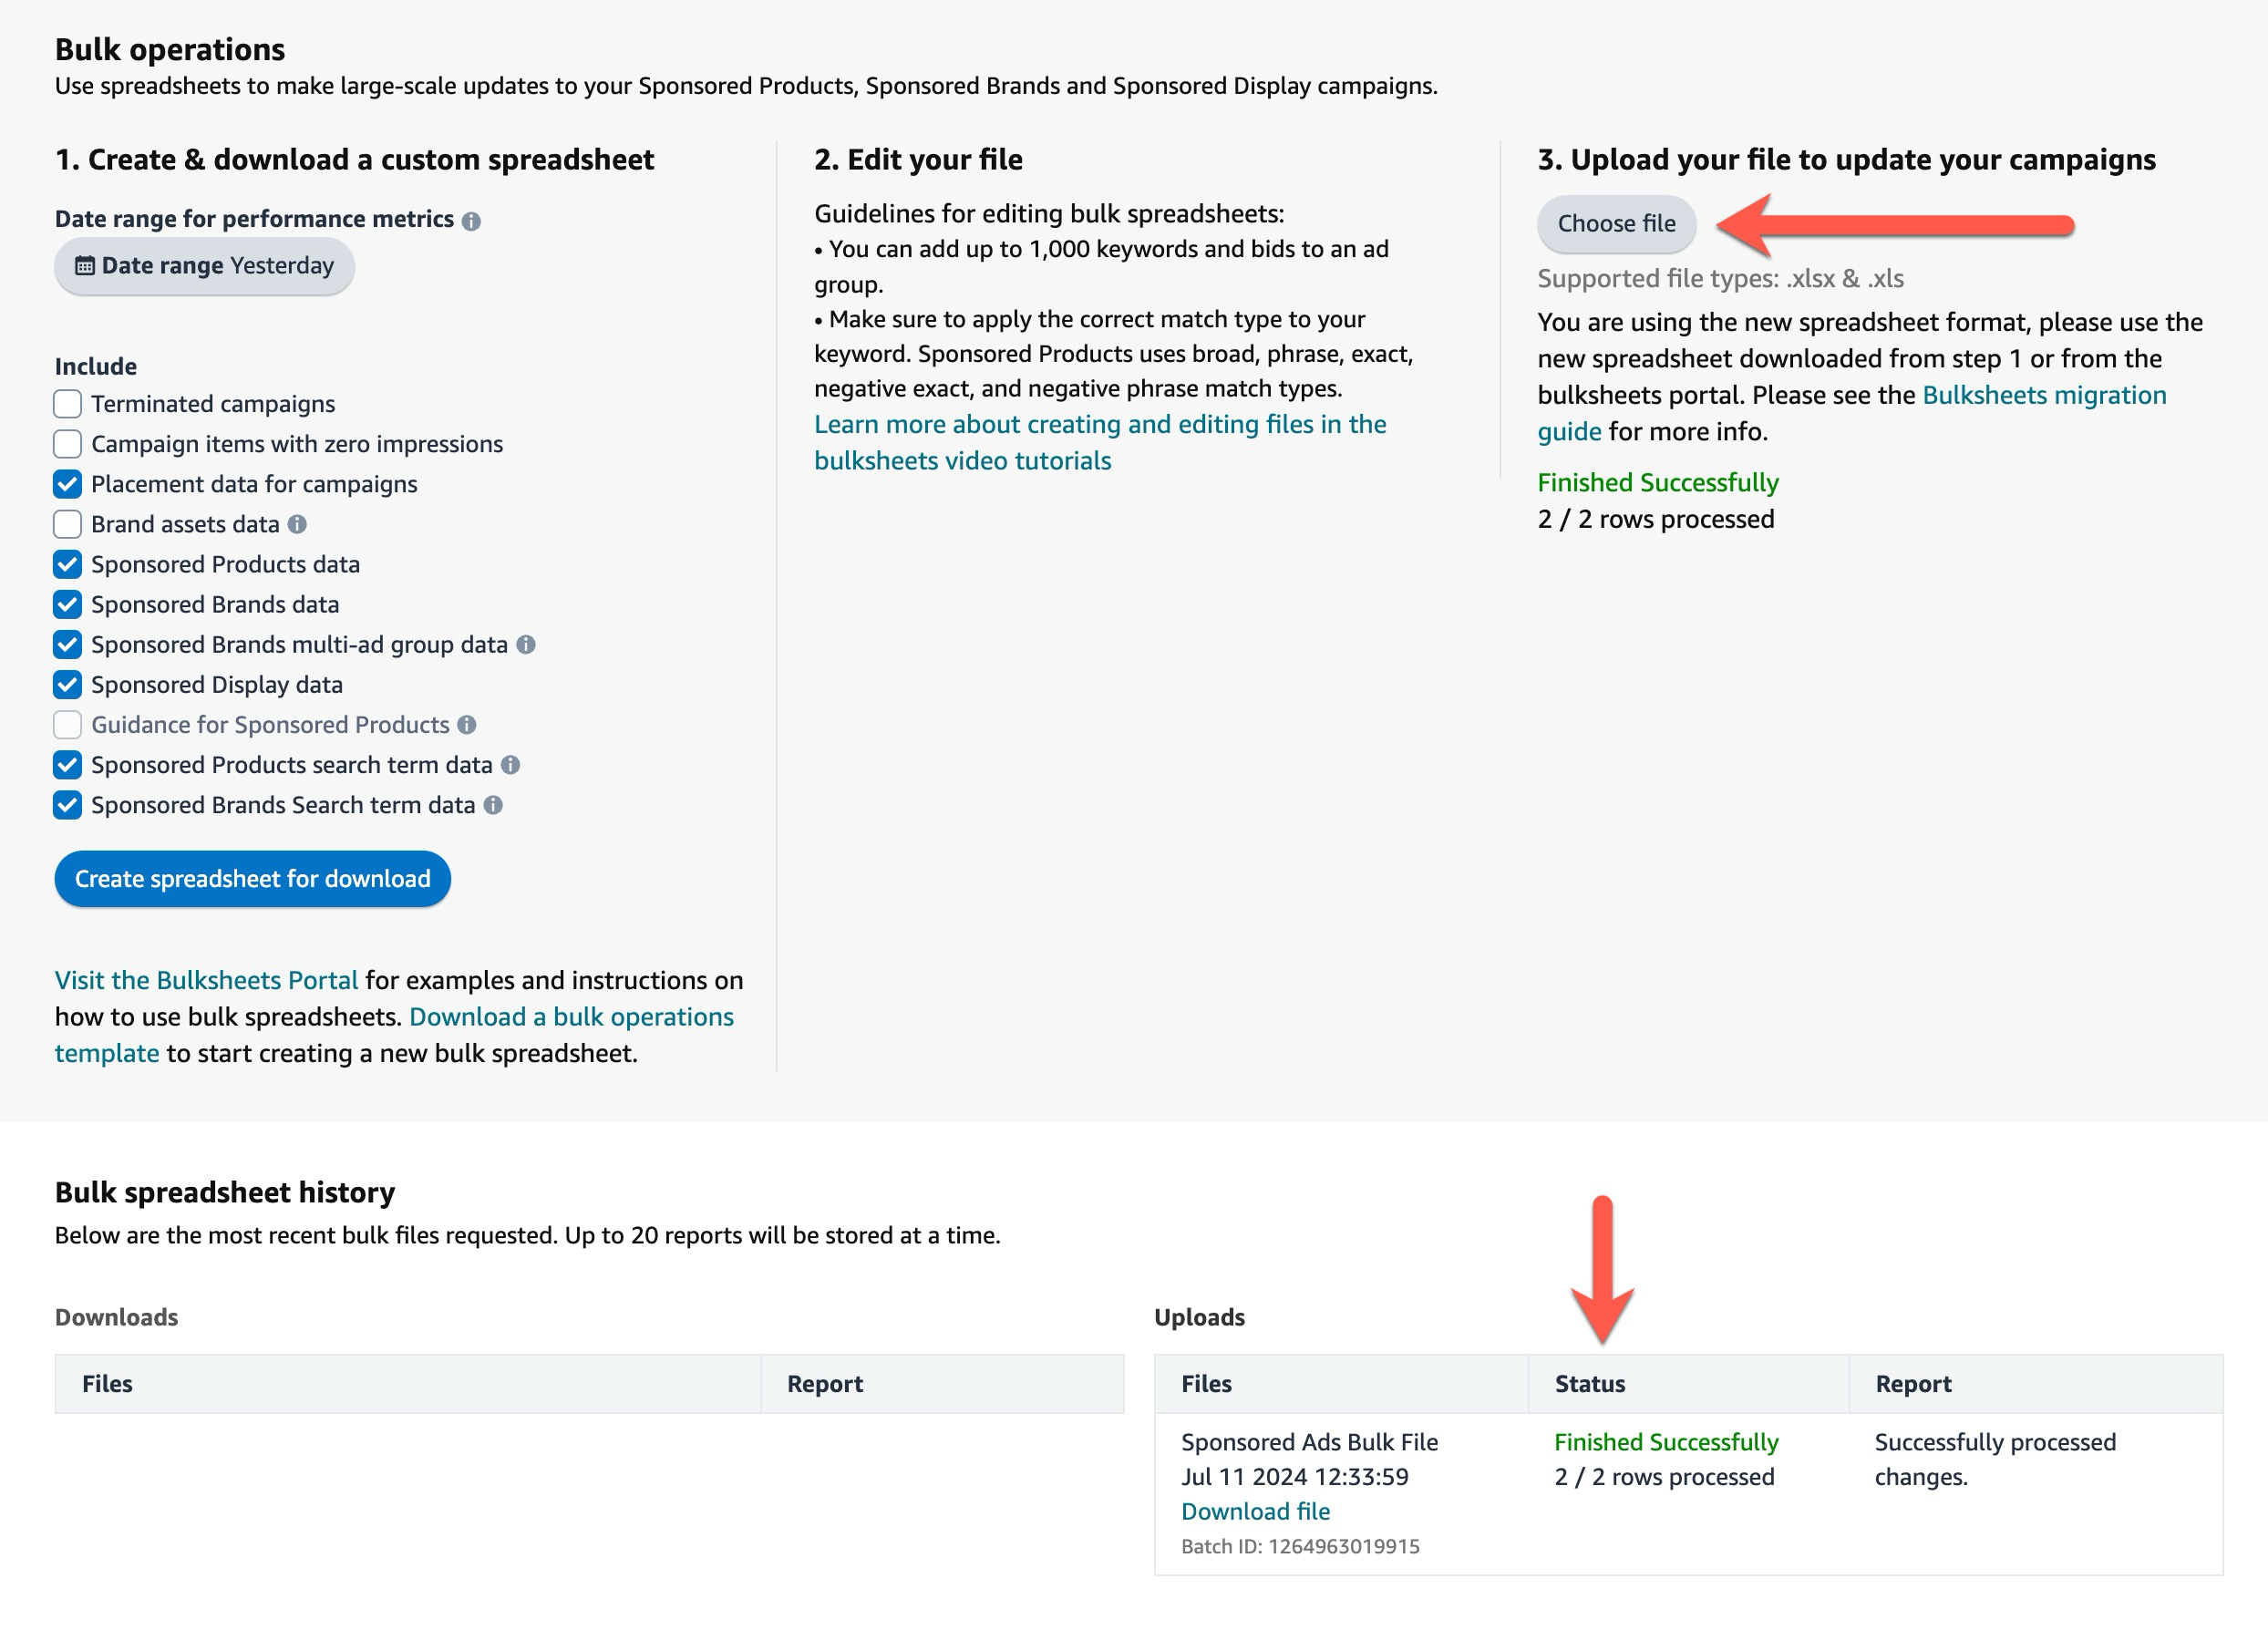

# Final thoughts

- Find the link to the script in the description
- What should we analyze? Let me know in the comments?
- Subscribe :)
- Check out our blog, e.g. at https://www.amalytix.com/en/blog/amazon-bulk-operations-python-pandas/ 
- Check out AMALYTIX itself at https://www.amalytix.com